In [1]:
import typing
from typing import Tuple
import json
import os

In [2]:
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

/Users/VarunMadhavan/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
import utils
from modules import Encoder, Decoder
from custom_types import DaRnnNet, TrainData, TrainConfig
from utils import numpy_to_tvar
from constants import device

In [5]:
logger = utils.setup_log()
logger.info(f"Using computation device: {device}")

2020-03-17 21:11:37,735 - VOC_TOPICS - INFO - Using computation device: cpu


In [6]:
def preprocess_data(dat, col_names) -> Tuple[TrainData, StandardScaler]:
    scale = StandardScaler().fit(dat)
    #proc_dat = scale.transform(dat)
    proc_dat = dat.to_numpy()

    mask = np.ones(proc_dat.shape[1], dtype=bool)
    dat_cols = list(dat.columns)
    for col_name in col_names:
        mask[dat_cols.index(col_name)] = False

    feats = proc_dat[:, mask]
    targs = proc_dat[:, ~mask]

    return TrainData(feats, targs), scale

In [8]:
def da_rnn(train_data: TrainData, n_targs: int, encoder_hidden_size=4, decoder_hidden_size=4,
           T=10, learning_rate=0.01, batch_size=64):

    train_cfg = TrainConfig(T, int(train_data.feats.shape[0] * 0.7), batch_size, nn.MSELoss())
    logger.info(f"Training size: {train_cfg.train_size:d}.")

    enc_kwargs = {"input_size": train_data.feats.shape[1], "hidden_size": encoder_hidden_size, "T": T}
    encoder = Encoder(**enc_kwargs).to(device)
    with open(os.path.join("data", "enc_kwargs.json"), "w") as fi:
        json.dump(enc_kwargs, fi, indent=4)

    dec_kwargs = {"encoder_hidden_size": encoder_hidden_size,
                  "decoder_hidden_size": decoder_hidden_size, "T": T, "out_feats": n_targs}
    decoder = Decoder(**dec_kwargs).to(device)
    with open(os.path.join("data", "dec_kwargs.json"), "w") as fi:
        json.dump(dec_kwargs, fi, indent=4)

    encoder_optimizer = optim.Adam(
        params=[p for p in encoder.parameters() if p.requires_grad],
        lr=learning_rate)
    decoder_optimizer = optim.Adam(
        params=[p for p in decoder.parameters() if p.requires_grad],
        lr=learning_rate)
    da_rnn_net = DaRnnNet(encoder, decoder, encoder_optimizer, decoder_optimizer)

    return train_cfg, da_rnn_net

In [9]:
def train(net: DaRnnNet, train_data: TrainData, t_cfg: TrainConfig, n_epochs=10, save_plots=False):
    iter_per_epoch = int(np.ceil(t_cfg.train_size * 1. / t_cfg.batch_size))
    iter_losses = np.zeros(n_epochs * iter_per_epoch)
    epoch_losses = np.zeros(n_epochs)
    logger.info(f"Iterations per epoch: {t_cfg.train_size * 1. / t_cfg.batch_size:3.3f} ~ {iter_per_epoch:d}.")

    n_iter = 0

    for e_i in range(n_epochs):
        perm_idx = np.random.permutation(t_cfg.train_size - t_cfg.T)

        for t_i in range(0, t_cfg.train_size, t_cfg.batch_size):
            batch_idx = perm_idx[t_i:(t_i + t_cfg.batch_size)]
            feats, y_history, y_target = prep_train_data(batch_idx, t_cfg, train_data)

            loss = train_iteration(net, t_cfg.loss_func, feats, y_history, y_target)
            iter_losses[e_i * iter_per_epoch + t_i // t_cfg.batch_size] = loss
            # if (j / t_cfg.batch_size) % 50 == 0:
            #    self.logger.info("Epoch %d, Batch %d: loss = %3.3f.", i, j / t_cfg.batch_size, loss)
            n_iter += 1

            adjust_learning_rate(net, n_iter)

        epoch_losses[e_i] = np.mean(iter_losses[range(e_i * iter_per_epoch, (e_i + 1) * iter_per_epoch)])

        if e_i % 10 == 0:
            y_test_pred = predict(net, train_data,
                                  t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                  on_train=False)
            # TODO: make this MSE and make it work for multiple inputs
            val_loss = y_test_pred - train_data.targs[t_cfg.train_size:]
            logger.info(f"Epoch {e_i:d}, train loss: {epoch_losses[e_i]:3.3f}, val loss: {np.mean(np.abs(val_loss))}.")
            y_train_pred = predict(net, train_data,
                                   t_cfg.train_size, t_cfg.batch_size, t_cfg.T,
                                   on_train=True)
            plt.figure()
            plt.plot(range(1, 1 + len(train_data.targs)), train_data.targs,
                     label="True")
            plt.plot(range(t_cfg.T, len(y_train_pred) + t_cfg.T), y_train_pred,
                     label='Predicted - Train')
            plt.plot(range(t_cfg.T + len(y_train_pred), len(train_data.targs) + 1), y_test_pred,
                     label='Predicted - Test')
            plt.legend(loc='upper left')
            utils.save_or_show_plot(f"pred_{e_i}.png", save_plots)

    return iter_losses, epoch_losses

In [10]:
def prep_train_data(batch_idx: np.ndarray, t_cfg: TrainConfig, train_data: TrainData):
    feats = np.zeros((len(batch_idx), t_cfg.T - 1, train_data.feats.shape[1]))
    y_history = np.zeros((len(batch_idx), t_cfg.T - 1, train_data.targs.shape[1]))
    y_target = train_data.targs[batch_idx + t_cfg.T]

    for b_i, b_idx in enumerate(batch_idx):
        b_slc = slice(b_idx, b_idx + t_cfg.T - 1)
        feats[b_i, :, :] = train_data.feats[b_slc, :]
        y_history[b_i, :] = train_data.targs[b_slc]

    return feats, y_history, y_target

In [11]:
def adjust_learning_rate(net: DaRnnNet, n_iter: int):
    # TODO: Where did this Learning Rate adjustment schedule come from?
    # Should be modified to use Cosine Annealing with warm restarts https://www.jeremyjordan.me/nn-learning-rate/
    if n_iter % 10000 == 0 and n_iter > 0:
        for enc_params, dec_params in zip(net.enc_opt.param_groups, net.dec_opt.param_groups):
            enc_params['lr'] = enc_params['lr'] * 0.9
            dec_params['lr'] = dec_params['lr'] * 0.9

In [12]:
def train_iteration(t_net: DaRnnNet, loss_func: typing.Callable, X, y_history, y_target):
    t_net.enc_opt.zero_grad()
    t_net.dec_opt.zero_grad()

    input_weighted, input_encoded = t_net.encoder(numpy_to_tvar(X))
    y_pred = t_net.decoder(input_encoded, numpy_to_tvar(y_history))

    y_true = numpy_to_tvar(y_target)
    loss = loss_func(y_pred, y_true)
    loss.backward()

    t_net.enc_opt.step()
    t_net.dec_opt.step()

    return loss.item()

In [13]:
def predict(t_net: DaRnnNet, t_dat: TrainData, train_size: int, batch_size: int, T: int, on_train=False):
    out_size = t_dat.targs.shape[1]
    if on_train:
        y_pred = np.zeros((train_size - T + 1, out_size))
    else:
        y_pred = np.zeros((t_dat.feats.shape[0] - train_size, out_size))

    for y_i in range(0, len(y_pred), batch_size):
        y_slc = slice(y_i, y_i + batch_size)
        batch_idx = range(len(y_pred))[y_slc]
        b_len = len(batch_idx)
        X = np.zeros((b_len, T - 1, t_dat.feats.shape[1]))
        y_history = np.zeros((b_len, T - 1, t_dat.targs.shape[1]))

        for b_i, b_idx in enumerate(batch_idx):
            if on_train:
                idx = range(b_idx, b_idx + T - 1)
            else:
                idx = range(b_idx + train_size - T, b_idx + train_size - 1)

            X[b_i, :, :] = t_dat.feats[idx, :]
            y_history[b_i, :] = t_dat.targs[idx]

        y_history = numpy_to_tvar(y_history)
        _, input_encoded = t_net.encoder(numpy_to_tvar(X))
        y_pred[y_slc] = t_net.decoder(input_encoded, y_history).cpu().data.numpy()

    return y_pred

In [14]:
save_plots = False
debug = False

In [15]:
raw_data = pd.read_csv('data/cleaned_data.csv')
raw_data.head()

,0
0,0.098453
1,0.122610
2,0.125399
3,0.067789
4,-0.141216


In [16]:
prev_week = raw_data.shift(7)
prev_week.columns = ['1']

In [17]:
data = pd.concat([raw_data, prev_week], axis = 1)
data = data[7:].reset_index(drop = True) #since there is no prev_week data for the first 7 days, I have discarded those rows
data.head()

,0,1
0,-0.096574,0.098453
1,-0.068217,0.122610
2,-0.005028,0.125399
3,0.064886,0.067789
4,0.117161,-0.141216


In [18]:
target_cols = ('0',)

In [19]:
len(data)

306

In [21]:
data, scaler = preprocess_data(data, target_cols)

2020-03-17 21:11:52,468 - VOC_TOPICS - INFO - Training size: 175.
2020-03-17 21:11:52,473 - VOC_TOPICS - INFO - Iterations per epoch: 1.367 ~ 2.
2020-03-17 21:11:52,540 - VOC_TOPICS - INFO - Epoch 0, train loss: 0.026, val loss: 0.16350440380420161.


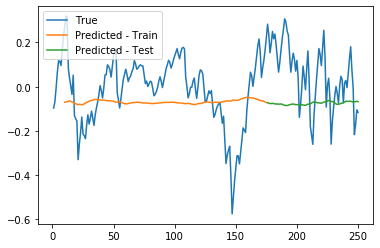

2020-03-17 21:11:53,260 - VOC_TOPICS - INFO - Epoch 10, train loss: 0.016, val loss: 0.11828225699371493.


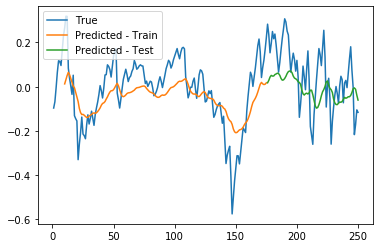

2020-03-17 21:11:54,064 - VOC_TOPICS - INFO - Epoch 20, train loss: 0.006, val loss: 0.10238886270345479.


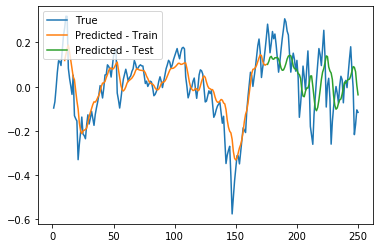

2020-03-17 21:11:54,782 - VOC_TOPICS - INFO - Epoch 30, train loss: 0.005, val loss: 0.10689605340736594.


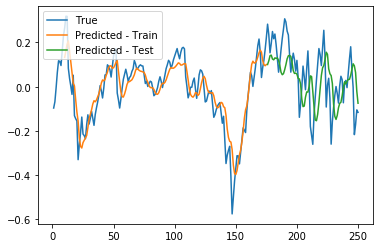

2020-03-17 21:11:55,471 - VOC_TOPICS - INFO - Epoch 40, train loss: 0.007, val loss: 0.10809154048525223.


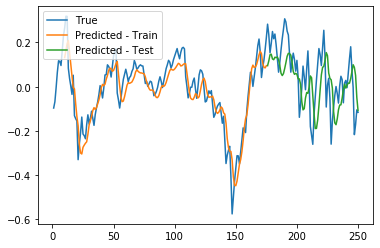

2020-03-17 21:11:56,120 - VOC_TOPICS - INFO - Epoch 50, train loss: 0.006, val loss: 0.10194045014600363.


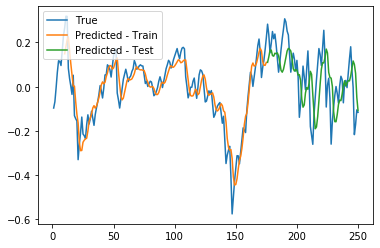

2020-03-17 21:11:56,836 - VOC_TOPICS - INFO - Epoch 60, train loss: 0.006, val loss: 0.10538384252158096.


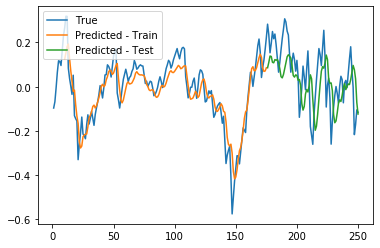

2020-03-17 21:11:57,578 - VOC_TOPICS - INFO - Epoch 70, train loss: 0.006, val loss: 0.10063084573804403.


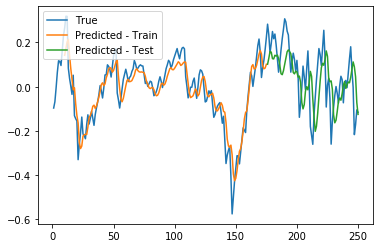

2020-03-17 21:11:58,256 - VOC_TOPICS - INFO - Epoch 80, train loss: 0.007, val loss: 0.10048818942458541.


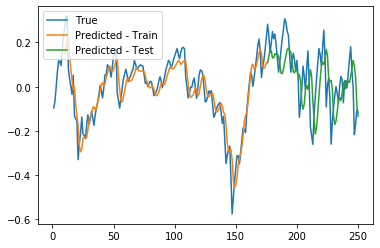

2020-03-17 21:11:58,990 - VOC_TOPICS - INFO - Epoch 90, train loss: 0.006, val loss: 0.10075374654019807.


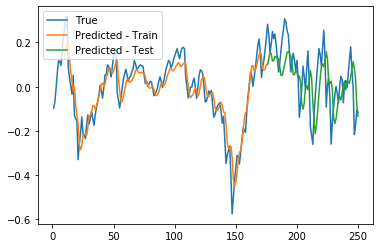

2020-03-17 21:11:59,751 - VOC_TOPICS - INFO - Epoch 100, train loss: 0.006, val loss: 0.10611870198716937.


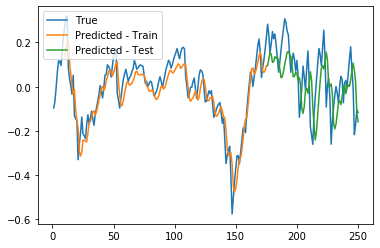

2020-03-17 21:12:00,415 - VOC_TOPICS - INFO - Epoch 110, train loss: 0.005, val loss: 0.10119190072939786.


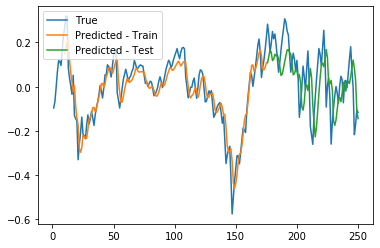

2020-03-17 21:12:01,066 - VOC_TOPICS - INFO - Epoch 120, train loss: 0.007, val loss: 0.09794345556089085.


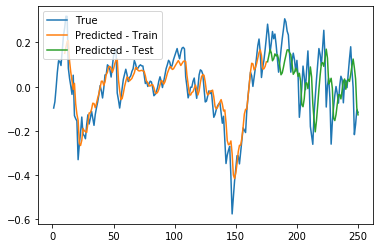

2020-03-17 21:12:01,719 - VOC_TOPICS - INFO - Epoch 130, train loss: 0.006, val loss: 0.09878760827967327.


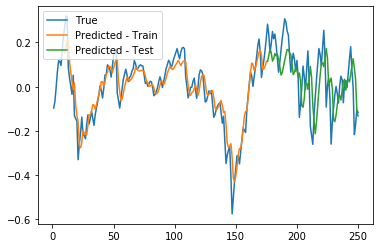

2020-03-17 21:12:02,359 - VOC_TOPICS - INFO - Epoch 140, train loss: 0.006, val loss: 0.09820918247267553.


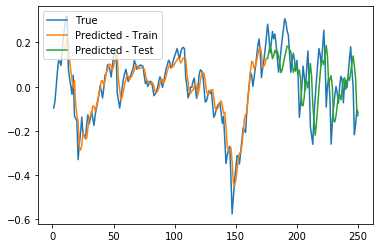

2020-03-17 21:12:03,003 - VOC_TOPICS - INFO - Epoch 150, train loss: 0.005, val loss: 0.10157710675591342.


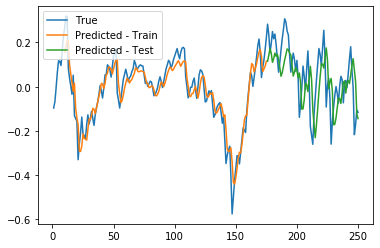

2020-03-17 21:12:03,785 - VOC_TOPICS - INFO - Epoch 160, train loss: 0.006, val loss: 0.09941956901620698.


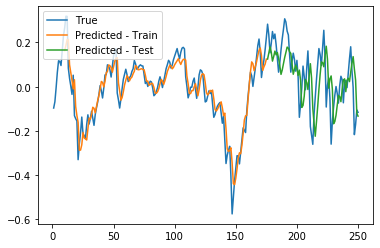

2020-03-17 21:12:04,538 - VOC_TOPICS - INFO - Epoch 170, train loss: 0.005, val loss: 0.1010098924147176.


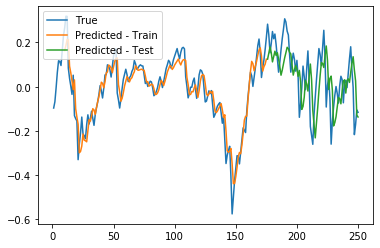

2020-03-17 21:12:05,305 - VOC_TOPICS - INFO - Epoch 180, train loss: 0.005, val loss: 0.09868120386052814.


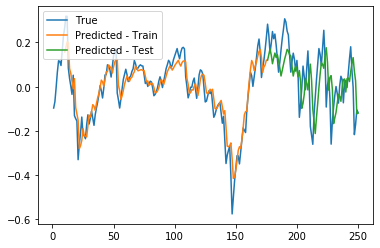

2020-03-17 21:12:05,994 - VOC_TOPICS - INFO - Epoch 190, train loss: 0.005, val loss: 0.09914814853738618.


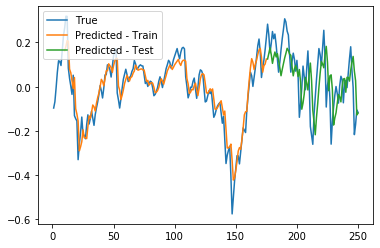

In [22]:
da_rnn_kwargs = {"batch_size": 128, "T": 10}
config, model = da_rnn(data, n_targs=len(target_cols), learning_rate=.01, **da_rnn_kwargs)
iter_loss, epoch_loss = train(model, data, config, n_epochs=200, save_plots=save_plots)
final_y_pred = predict(model, data, config.train_size, config.batch_size, config.T)

In [23]:
final_y_pred.shape

(75, 1)

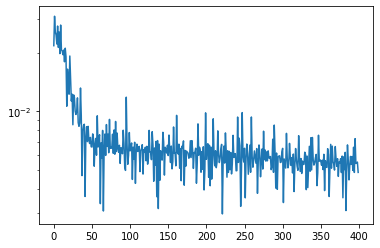

In [24]:
plt.figure()
plt.semilogy(range(len(iter_loss)), iter_loss)
utils.save_or_show_plot("iter_loss.png", save_plots)

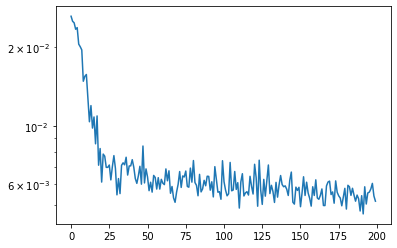

In [25]:
plt.figure()
plt.semilogy(range(len(epoch_loss)), epoch_loss)
utils.save_or_show_plot("epoch_loss.png", save_plots)

In [26]:
#500 epochs - MAE = 0.016413153912241216
#200 epochs - MAE = 0.015500509950411129 # 200 seems best
#100 epochs - MAE = 0.016767046791350583
print('MAE = {}'.format(mean_squared_error(data.targs[config.train_size:], final_y_pred)))

MAE = 0.015394749046980677


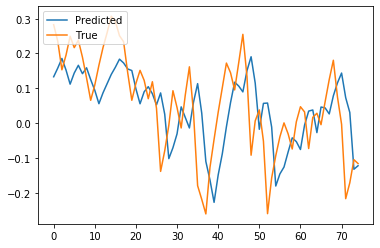

In [27]:
#hidden_dim = 16
plt.figure()
plt.plot(final_y_pred, label='Predicted')
plt.plot(data.targs[config.train_size:], label="True")
plt.legend(loc='upper left')
utils.save_or_show_plot("final_predicted.png", save_plots)

56

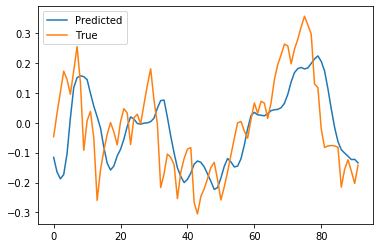

In [40]:
#5
plt.figure()
plt.plot(final_y_pred, label='Predicted')
plt.plot(data.targs[config.train_size:], label="True")
plt.legend(loc='upper left')
utils.save_or_show_plot("final_predicted.png", save_plots)

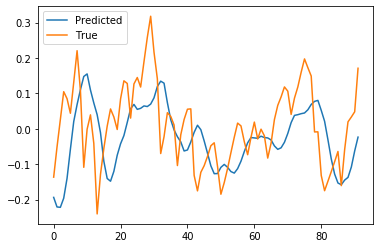

In [30]:
#10
plt.figure()
plt.plot(final_y_pred, label='Predicted')
plt.plot(data.targs[config.train_size:], label="True")
plt.legend(loc='upper left')
utils.save_or_show_plot("final_predicted.png", save_plots)

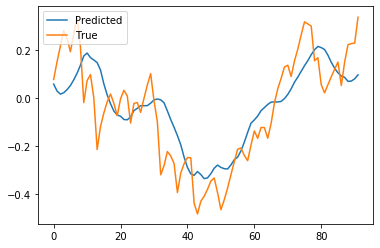

In [60]:
#4
plt.figure()
plt.plot(final_y_pred, label='Predicted')
plt.plot(data.targs[config.train_size:], label="True")
plt.legend(loc='upper left')
utils.save_or_show_plot("final_predicted.png", save_plots)

In [42]:
with open(os.path.join("data", "da_rnn_kwargs.json"), "w") as fi:
    json.dump(da_rnn_kwargs, fi, indent=4)

In [43]:
joblib.dump(scaler, os.path.join("data", "scaler.pkl"))
torch.save(model.encoder.state_dict(), os.path.join("data", "encoder.torch"))
torch.save(model.decoder.state_dict(), os.path.join("data", "decoder.torch"))